# SVM

支持向量机 SVM 与 上一节的线性感知机类似——找一个超平面来区分正负样本，但是SVM与感知机的区别是：他要求正负样本中离超平面最近的点的几何间隔尽可能的大（max-最小几何间隔）。

其用拉格朗日法最终得到:

$$
L(w,b,\alpha) = \frac{1}{2}||w||^2 - \sum_{i=1}^N \alpha_i[y_i(wx_i+b)-1]
$$

默认满足 KKT 条件，可以将问题转化为其强对偶式：

$$
max_{\alpha}min_{w,b} L(w,b,\alpha)
$$

先求解 $min_{w,b} L(w,b,\alpha)$，对 $w, b$ 求导并令等于0，即得到极值点。

---

显然，等价于如下优化问题（设为$Q^*$）：

$$
\min_{\alpha} \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N\alpha_i\alpha_jy_iy_jx_i^Tx_j-\sum_{i=1}^N\alpha_i\\
s.t.\sum_{i=1}^N\alpha_iy_i=0,\\
\alpha_i\geq0,i=1,2,...,N
$$

## SMO 求解对偶问题的最优解

序列最小化最优化算法(sequential minimal optimization,SMO) 是求解SVM对偶问题的一种启发式算法，它的思路是：
每次只选择一个变量优化，而固定住其他变量，比如选择 $\alpha_1$ 进行优化，而固定住 $\alpha_i,i=2,3,...,N$，但由于我们的问题中有一个约束：$\sum_i^N\alpha_iy_i=0$，需要另外选择一个$\alpha_2$来配合$\alpha_1$做改变，当两者中任何一个变量确定后，另外一个也就随之确定了，比如确定$\alpha_2$后：
$$
\alpha_1=-y_1\sum_{i=2}^N\alpha_iy_i \tag{1}
$$
所以在每个子问题中将同时更新两个变量。

### 选择两个变量后，如果优化？

不失一般性的选择两个变量 $\alpha_1, \alpha_2$，其他变量 $\alpha_i$ 都视作常量（在$Q^*$中可以忽略）。于是 SMO 的最优化问题的子问题可以写为:

$$
\begin{align}
\min_{\alpha_1,\alpha_2} W(\alpha_1, \alpha_2)&=\frac{1}{2}K_{11}\alpha_1^2+\frac{1}{2}K_{22}\alpha_2^2 + y_1y_2K_{12}\alpha_1\alpha_2 - (\alpha_1+\alpha_2) \\
&+y_1\alpha_1\sum_{i=3}^Ny_i\alpha_ix_iK_{i1} + y_2\alpha_2 \sum_{i=3}^Ny_i\alpha_iK_{i2}  + c
\end{align}
$$

$
\begin{align}
&s.t.\alpha_1y_1+\alpha_2y_2 = -\sum_{i=3}^N\alpha_iy_i=\zeta\\
&0 \le \alpha_i \le C, i = 1, 2
\end{align}
$

&emsp;&emsp;其中 $c$ 是与 $\alpha_1, \alpha_2$无关的部分，在本次优化中当作常数项处理。由 SVM 优化目标函数的约束条件

将 $(1)$ 式带入到上式中，消掉 $\alpha_1$后就可以发现，优化的目标函数是关于 $\alpha_2$ 的二次函数（且开口朝上）：

$$
\min_{\alpha_2}\frac{1}{2}(x_1-x_2)^T(x_1-x_2)\alpha_2^2+(-y_2\eta x_1^Tx_1+y_1\eta x_1^Tx_2+\frac{1}{2}y_2x_2^T\gamma-\frac{1}{2}y_2x_1^T\gamma-1+y_1y_2)\alpha_2 \\
s.t.\alpha_2\geq0,y_1(\eta-\alpha_2y_2)\geq0
$$


这里，$\eta=-\sum_{i=3}^N\alpha_iy_i$， $\gamma=\sum_{i=3}^N\alpha_iy_ix_i$

所以该问题无约束的最优解为：

$$
\alpha_2^{unc}=-\frac{-y_2\eta x_1^Tx_1+y_1\eta x_1^Tx_2+\frac{1}{2}y_2x_2^T\gamma-\frac{1}{2}y_2x_1^T\gamma-1+y_1y_2}{(x_1-x_2)^T(x_1-x_2)} \tag{2}
$$
接下来，我们对上面的表达式做一些优化，大家注意每次迭代时，$\gamma,\eta$都有大量的重复计算（每次仅修改了$\alpha$的两个变量，剩余部分其实无需重复计算），而且对于$\alpha_1,\alpha_2$的更新也没有有效利用它上一阶段的取值（记作$\alpha_1^{old},\alpha_2^{old}$）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import os
os.chdir('../')
from models import utils
%matplotlib inline

In [2]:
#定义一个绘制决策边界以及支持向量的函数（并放到utils中）
def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    # 绘制支持向量
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', alpha=0.7, edgecolor='red')

In [3]:
"""
硬间隔支持向量机的smo实现,放到ml_models.svm模块
"""
class HardMarginSVM(object):
    def __init__(self, epochs=100):
        self.w = None
        self.b = None
        self.alpha = None
        self.E = None
        self.epochs = epochs
        # 记录支持向量
        self.support_vectors = None

    def init_params(self, X, y):
        """
        :param X: (n_samples,n_features)
        :param y: (n_samples,) y_i\in\{0,1\}
        :return:
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = .0
        self.alpha = np.zeros(n_samples)
        self.E = np.zeros(n_samples)
        # 初始化E
        for i in range(0, n_samples):
            self.E[i] = np.dot(self.w, X[i, :]) + self.b - y[i]

    def _select_j(self, best_i):
        """
        选择j
        :param best_i:
        :return:
        """
        valid_j_list = [i for i in range(0, len(self.alpha)) if self.alpha[i] > 0 and i != best_i]
        best_j = -1
        # 优先选择使得|E_i-E_j|最大的j
        if len(valid_j_list) > 0:
            max_e = 0
            for j in valid_j_list:
                current_e = np.abs(self.E[best_i] - self.E[j])
                if current_e > max_e:
                    best_j = j
                    max_e = current_e
        else:
            # 随机选择
            l = list(range(len(self.alpha)))
            seq = l[: best_i] + l[best_i + 1:]
            best_j = random.choice(seq)
        return best_j

    def _meet_kkt(self, w, b, x_i, y_i, alpha_i):
        """
        判断是否满足KKT条件

        :param w:
        :param b:
        :param x_i:
        :param y_i:
        :return:
        """
        if alpha_i < 1e-7:
            return y_i * (np.dot(w, x_i) + b) >= 1
        else:
            return abs(y_i * (np.dot(w, x_i) + b) - 1) < 1e-7

    def fit(self, X, y2, show_train_process=False):
        """

        :param X:
        :param y2:
        :param show_train_process: 显示训练过程
        :return:
        """
        y = copy.deepcopy(y2)
        y[y == 0] = -1
        # 初始化参数
        self.init_params(X, y)
        for _ in range(0, self.epochs):
            if_all_match_kkt = True
            for i in range(0, len(self.alpha)):
                x_i = X[i, :]
                y_i = y[i]
                alpha_i_old = self.alpha[i]
                E_i_old = self.E[i]
                # 外层循环：选择违反KKT条件的点i
                if not self._meet_kkt(self.w, self.b, x_i, y_i, alpha_i_old):
                    if_all_match_kkt = False
                    # 内层循环，选择使|Ei-Ej|最大的点j
                    best_j = self._select_j(i)

                    alpha_j_old = self.alpha[best_j]
                    x_j = X[best_j, :]
                    y_j = y[best_j]
                    E_j_old = self.E[best_j]

                    # 进行更新
                    # 1.首先获取无裁剪的最优alpha_2
                    eta = np.dot(x_i - x_j, x_i - x_j)
                    # 如果x_i和x_j很接近，则跳过
                    if eta < 1e-3:
                        continue
                    alpha_j_unc = alpha_j_old + y_j * (E_i_old - E_j_old) / eta
                    # 2.裁剪并得到new alpha_2
                    if y_i == y_j:
                        if alpha_j_unc < 0:
                            alpha_j_new = 0
                        elif 0 <= alpha_j_unc <= alpha_i_old + alpha_j_old:
                            alpha_j_new = alpha_j_unc
                        else:
                            alpha_j_new = alpha_i_old + alpha_j_old
                    else:
                        if alpha_j_unc < max(0, alpha_j_old - alpha_i_old):
                            alpha_j_new = max(0, alpha_j_old - alpha_i_old)
                        else:
                            alpha_j_new = alpha_j_unc

                    # 如果变化不够大则跳过
                    if np.abs(alpha_j_new - alpha_j_old) < 1e-5:
                        continue
                    # 3.得到alpha_1_new
                    alpha_i_new = alpha_i_old + y_i * y_j * (alpha_j_old - alpha_j_new)
                    # 4.更新w
                    self.w = self.w + (alpha_i_new - alpha_i_old) * y_i * x_i + (alpha_j_new - alpha_j_old) * y_j * x_j
                    # 5.更新alpha_1,alpha_2
                    self.alpha[i] = alpha_i_new
                    self.alpha[best_j] = alpha_j_new
                    # 6.更新b
                    b_i_new = y_i - np.dot(self.w, x_i)
                    b_j_new = y_j - np.dot(self.w, x_j)
                    if alpha_i_new > 0:
                        self.b = b_i_new
                    elif alpha_j_new > 0:
                        self.b = b_j_new
                    else:
                        self.b = (b_i_new + b_j_new) / 2.0
                    # 7.更新E
                    for k in range(0, len(self.E)):
                        self.E[k] = np.dot(self.w, X[k, :]) + self.b - y[k]
                    # 显示训练过程
                    if show_train_process is True:
                        utils.plot_decision_function(X, y2, self, [i, best_j])
                        utils.plt.pause(0.1)
                        utils.plt.clf()

            # 如果所有的点都满足KKT条件，则中止
            if if_all_match_kkt is True:
                break
        # 计算支持向量
        self.support_vectors = np.where(self.alpha > 1e-3)[0]
        # 利用所有的支持向量，更新b
        self.b = np.mean([y[s] - np.dot(self.w, X[s, :]) for s in self.support_vectors.tolist()])
        # 显示最终结果
        if show_train_process is True:
            utils.plot_decision_function(X, y2, self, self.support_vectors)
            utils.plt.show()

    def get_params(self):
        """
        输出原始的系数
        :return: w
        """

        return self.w, self.b

    def predict_proba(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        return utils.sigmoid(x.dot(self.w) + self.b)

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        proba = self.predict_proba(x)
        return (proba >= 0.5).astype(int)

## 验证

In [4]:
from sklearn.datasets import make_classification
# 生成分类数据
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=2.0)

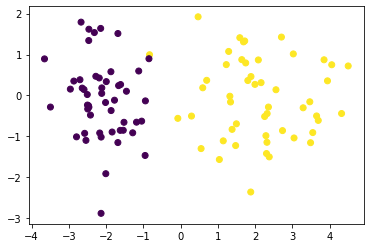

In [5]:
plt.scatter(data[:,0],data[:,1],c=target)

In [6]:
#训练
svm = HardMarginSVM()
svm.fit(data, target)

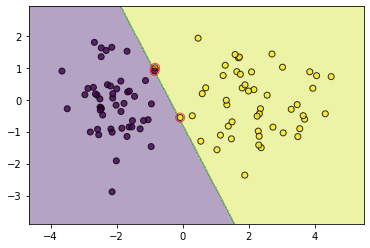

In [7]:
plot_decision_function(data, target, svm, svm.support_vectors)

## 问题讨论
1.非线可分的情况如何处理？
大家可以将上面的代码多运行几次，可以发现如果有异常点等情况出现时（即线性不可分时），模型训练的结果会很难看，后面小节将会对这种情况做处理，教模型如何去“容忍”这些不好看的点，或者巧妙地通过坐标映射的方式将低维数据映射到高维空间进而可以线性可分

2.原问题本就是凸优化问题，为何还要转对偶问题求解？
个人觉得更多是为了引入核技巧，因为对偶问题进行计算时，有关于两个点内积的计算：$x_i^Tx_j$，这可以方便的用核函数替代$\kappa(x_i,x_j)$，便于处理非线性可分的情况